In [86]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.6.0
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


In [87]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6016750628256796913,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9898950656
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11529088064624138587
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, UpSampling2D, AveragePooling2D,ZeroPadding2D,Convolution2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from IPython.display import SVG, Image
import cv2
import utils

In [89]:
class_names = []
for types in os.listdir("BrainTumor_Augmented/"):
    print(str(len(os.listdir("BrainTumor_Augmented/"+ types)))+" "+ types+' images')
    class_names.append(types)

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

1036 no images
971 yes images


In [90]:
from imutils import paths
import random
import shutil
import os

# # There will be a head folder which is named "PlantDiseaseData-master-distributed". Inside the head folder, there will be a main folder "PlantDiseaseData-master-distributed/main/". 
# # Inside this main folder, the pictures will be there which will be splitted.
# # Result folders will be "PlantDiseaseData-master-distributed/training/","PlantDiseaseData-master-distributed/testing/", "PlantDiseaseData-master-distributed/validation/" 
INPUT_DATASET = "BrainTumor_Augmented/"
BASE_PATH = 'BrainTumor_Augmented/'

TRAIN_PATH = os.path.sep.join([BASE_PATH, "training/"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation/"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing/"])

TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.111

 
# # grab the paths to all input images in the original input directory
# # and shuffle them
imagePaths = list(paths.list_images(INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

# # compute the training and testing split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]
 
# # we'll be using part of the training data for validation
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

# # define the datasets that we'll be building
datasets = [
	("training", trainPaths, TRAIN_PATH),
	("validation", valPaths, VAL_PATH),
	("testing", testPaths, TEST_PATH)
]

# # loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
 
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
 
	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]
 
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
 
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
 
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating BrainTumor_Augmented/\training/' directory
[INFO] 'creating BrainTumor_Augmented/\training/\BrainTumor_Augmented/yes' directory
[INFO] 'creating BrainTumor_Augmented/\training/\BrainTumor_Augmented/no' directory
[INFO] building 'validation' split
[INFO] 'creating BrainTumor_Augmented/\validation/' directory
[INFO] 'creating BrainTumor_Augmented/\validation/\BrainTumor_Augmented/no' directory
[INFO] 'creating BrainTumor_Augmented/\validation/\BrainTumor_Augmented/yes' directory
[INFO] building 'testing' split
[INFO] 'creating BrainTumor_Augmented/\testing/' directory
[INFO] 'creating BrainTumor_Augmented/\testing/\BrainTumor_Augmented/no' directory
[INFO] 'creating BrainTumor_Augmented/\testing/\BrainTumor_Augmented/yes' directory


In [154]:
img_size=80
batch_size = 32
datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory("BrainTumor_Augmented/training/BrainTumor_Augmented",
target_size=(img_size,img_size),
batch_size=batch_size,
class_mode='categorical',
color_mode ="grayscale",
shuffle=True)

datagen_validation=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_validation.flow_from_directory("BrainTumor_Augmented/validation/BrainTumor_Augmented",
target_size=(img_size,img_size),
batch_size=batch_size,
class_mode='categorical',
color_mode ="grayscale",
shuffle=True)

datagen_test=ImageDataGenerator(horizontal_flip=True)
test_generator=datagen_test.flow_from_directory("BrainTumor_Augmented/testing/BrainTumor_Augmented",
target_size=(img_size,img_size),
batch_size=batch_size,
class_mode='categorical',
color_mode ="grayscale",
shuffle=True)

Found 1606 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 201 images belonging to 2 classes.


In [191]:
detection = Sequential()
detection.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(80, 80, 1)))
detection.add(BatchNormalization())
detection.add(Conv2D(32, (3, 3), activation='relu',  padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))


detection.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
detection.add(BatchNormalization())
detection.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))


detection.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
detection.add(BatchNormalization())
detection.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))


detection.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
detection.add(BatchNormalization())
detection.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))
detection.add(Dropout(0.15))

detection.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
detection.add(BatchNormalization())
detection.add(Conv2D(384, (3, 3), activation='relu',padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))
detection.add(Dropout(0.15))

detection.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
detection.add(BatchNormalization())
detection.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
detection.add(BatchNormalization())
detection.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))
detection.add(Dropout(0.15))

detection.add(Flatten())
detection.add(Dense(512, activation='relu'))
detection.add(Dense(2, activation='sigmoid'))
optimum= Adam(learning_rate=0.0001)


def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

detection.compile(loss='binary_crossentropy', optimizer=optimum, metrics=['accuracy',recall,precision,tf.keras.metrics.AUC(curve="ROC"),tf.keras.metrics.FalsePositives(),tf.keras.metrics.TruePositives(),tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [192]:
detection.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_303 (Conv2D)          (None, 80, 80, 32)        320       
_________________________________________________________________
batch_normalization_330 (Bat (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_304 (Conv2D)          (None, 80, 80, 32)        9248      
_________________________________________________________________
batch_normalization_331 (Bat (None, 80, 80, 32)        128       
_________________________________________________________________
max_pooling2d_212 (MaxPoolin (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_305 (Conv2D)          (None, 40, 40, 64)        18496     
_________________________________________________________________
batch_normalization_332 (Bat (None, 40, 40, 64)      

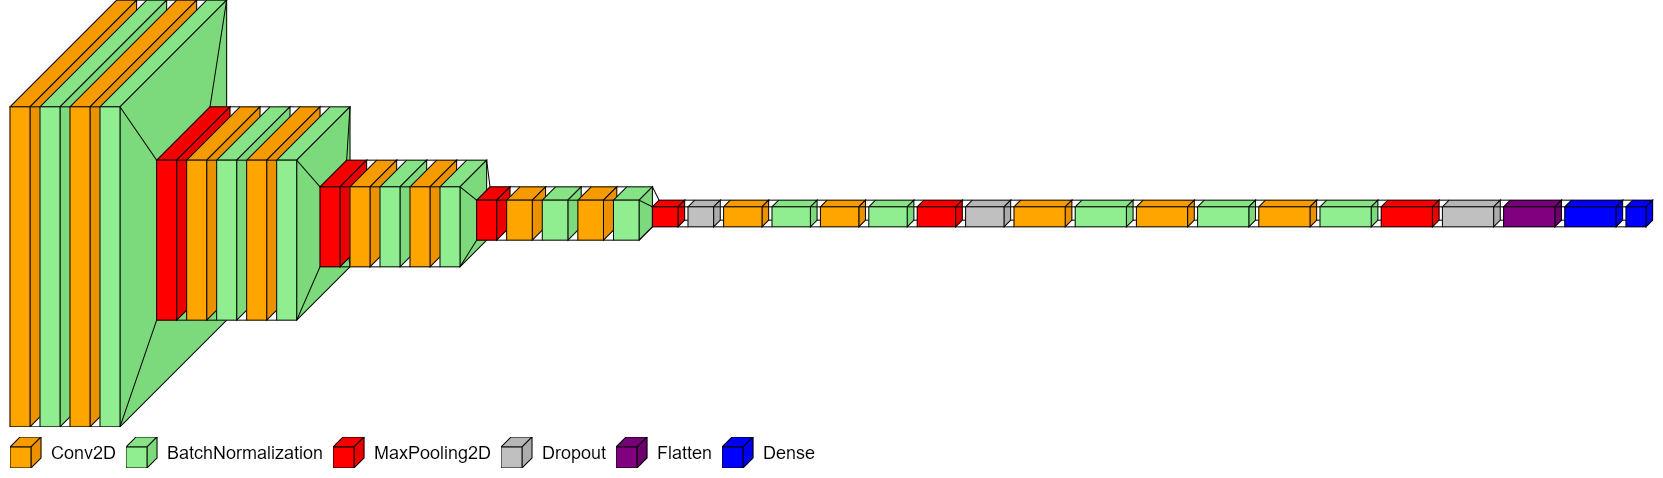

In [193]:
from PIL import ImageFont
from collections import defaultdict

font = ImageFont.truetype("arial.ttf", 18) 

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'silver'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'blue'
color_map[Flatten]['fill'] = 'purple'
color_map[BatchNormalization]['fill'] = 'lightgreen'

import visualkeras
visualkeras.layered_view(detection, legend=True,font=font,color_map=color_map)

In [194]:
%%time
batch_size = 32


ephocs=30
                    

steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch
validation_steps=validation_generator.n//validation_generator.batch_size
validation_steps
mod = detection.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=ephocs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps
                    )


Epoch 1/30
50/50 [==============================] - 4s 51ms/step - loss: 0.5871 - accuracy: 0.7332 - recall: 0.7104 - precision: 0.7088 - auc_34: 0.7910 - false_positives_34: 446.0000 - true_positives_34: 1128.0000 - sensitivity_at_specificity_34: 0.8736 - val_loss: 0.6934 - val_accuracy: 0.4688 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc_34: 0.5174 - val_false_positives_34: 0.0000e+00 - val_true_positives_34: 0.0000e+00 - val_sensitivity_at_specificity_34: 0.2031
Epoch 2/30
50/50 [==============================] - 2s 38ms/step - loss: 0.4037 - accuracy: 0.8253 - recall: 0.8310 - precision: 0.8267 - auc_34: 0.9018 - false_positives_34: 282.0000 - true_positives_34: 1308.0000 - sensitivity_at_specificity_34: 0.9638 - val_loss: 0.7109 - val_accuracy: 0.4688 - val_recall: 0.4688 - val_precision: 0.4688 - val_auc_34: 0.5659 - val_false_positives_34: 102.0000 - val_true_positives_34: 90.0000 - val_sensitivity_at_specificity_34: 0.4688
Epoch 3/30
50/50 [===================

In [195]:
# pred = detection.predict(test_generator, steps = len(test_generator), verbose = 1)

# predicted_class_indices = np.argmax(pred, axis = 1)

# # print(pred)

#Test Accuracy 
detection.evaluate(test_generator,verbose=1)

7/7 [==============================] - 0s 32ms/step - loss: 0.0215 - accuracy: 0.9900 - recall: 0.9955 - precision: 0.9913 - auc_34: 0.9998 - false_positives_34: 2.0000 - true_positives_34: 200.0000 - sensitivity_at_specificity_34: 1.0000


[0.021474691107869148,
 0.9900497794151306,
 0.9955357313156128,
 0.9913420081138611,
 0.9998267889022827,
 2.0,
 200.0,
 1.0]

In [225]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

layer_outputs = [layer.output for layer in detection.layers[1:]]
layer_outputs

[<KerasTensor: shape=(None, 80, 80, 32) dtype=float32 (created by layer 'batch_normalization_330')>,
 <KerasTensor: shape=(None, 80, 80, 32) dtype=float32 (created by layer 'conv2d_304')>,
 <KerasTensor: shape=(None, 80, 80, 32) dtype=float32 (created by layer 'batch_normalization_331')>,
 <KerasTensor: shape=(None, 40, 40, 32) dtype=float32 (created by layer 'max_pooling2d_212')>,
 <KerasTensor: shape=(None, 40, 40, 64) dtype=float32 (created by layer 'conv2d_305')>,
 <KerasTensor: shape=(None, 40, 40, 64) dtype=float32 (created by layer 'batch_normalization_332')>,
 <KerasTensor: shape=(None, 40, 40, 64) dtype=float32 (created by layer 'conv2d_306')>,
 <KerasTensor: shape=(None, 40, 40, 64) dtype=float32 (created by layer 'batch_normalization_333')>,
 <KerasTensor: shape=(None, 20, 20, 64) dtype=float32 (created by layer 'max_pooling2d_213')>,
 <KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'conv2d_307')>,
 <KerasTensor: shape=(None, 20, 20, 128) dtype=float3

In [226]:
visualize_model = tf.keras.models.Model(inputs=detection.input,outputs=layer_outputs)

In [227]:
img = load_img('sample1.jpg',target_size=(80,80))
img=tf.image.rgb_to_grayscale(img, name='sample1.jpg')

In [228]:
x= img_to_array(img)

In [229]:
x.shape

(80, 80, 1)

In [230]:
x=x.reshape((1,80,80,1))
x.shape

(1, 80, 80, 1)

In [231]:
x=x/255
x

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)

In [232]:
feature_maps=visualize_model.predict(x)

In [233]:
print(len(feature_maps))

37


In [234]:
layer_names = [layer.name for layer in detection.layers]
print(layer_names)


['conv2d_303', 'batch_normalization_330', 'conv2d_304', 'batch_normalization_331', 'max_pooling2d_212', 'conv2d_305', 'batch_normalization_332', 'conv2d_306', 'batch_normalization_333', 'max_pooling2d_213', 'conv2d_307', 'batch_normalization_334', 'conv2d_308', 'batch_normalization_335', 'max_pooling2d_214', 'conv2d_309', 'batch_normalization_336', 'conv2d_310', 'batch_normalization_337', 'max_pooling2d_215', 'dropout_87', 'conv2d_311', 'batch_normalization_338', 'conv2d_312', 'batch_normalization_339', 'max_pooling2d_216', 'dropout_88', 'conv2d_313', 'batch_normalization_340', 'conv2d_314', 'batch_normalization_341', 'conv2d_315', 'batch_normalization_342', 'max_pooling2d_217', 'dropout_89', 'flatten_52', 'dense_86', 'dense_87']


In [235]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

(1, 80, 80, 32)
(1, 80, 80, 32)
(1, 80, 80, 32)
(1, 40, 40, 32)
(1, 40, 40, 64)
(1, 40, 40, 64)
(1, 40, 40, 64)
(1, 40, 40, 64)
(1, 20, 20, 64)
(1, 20, 20, 128)


C:\Users\Admin\AppData\Local\Temp/ipykernel_6936/2306229206.py:10: RuntimeWarning: invalid value encountered in true_divide
  x/=x.std()
C:\Users\Admin\AppData\Local\Temp/ipykernel_6936/2306229206.py:10: RuntimeWarning: divide by zero encountered in true_divide
  x/=x.std()


(1, 20, 20, 128)
(1, 20, 20, 128)
(1, 20, 20, 128)
(1, 10, 10, 128)
(1, 10, 10, 256)
(1, 10, 10, 256)
(1, 10, 10, 256)
(1, 10, 10, 256)
(1, 5, 5, 256)
(1, 5, 5, 256)
(1, 5, 5, 384)
(1, 5, 5, 384)
(1, 5, 5, 384)
(1, 5, 5, 384)
(1, 2, 2, 384)
(1, 2, 2, 384)


C:\Users\Admin\AppData\Local\Temp/ipykernel_6936/2306229206.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(scale*channels,scale))


(1, 2, 2, 512)
(1, 2, 2, 512)
(1, 2, 2, 512)
(1, 2, 2, 512)
(1, 2, 2, 512)
(1, 2, 2, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 512)
(1, 512)
(1, 2)


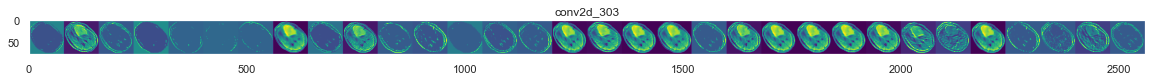

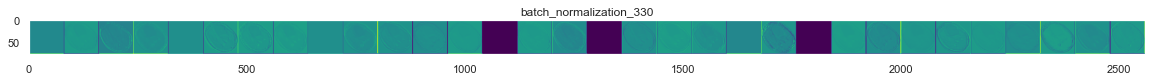

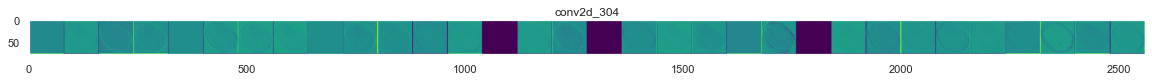

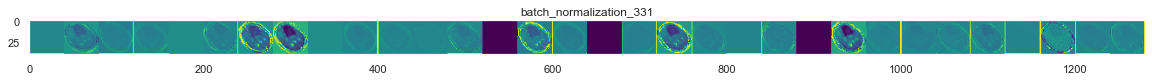

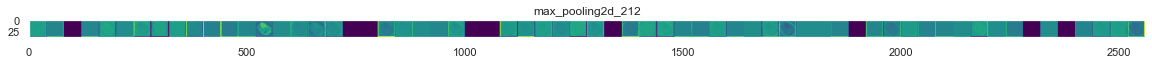

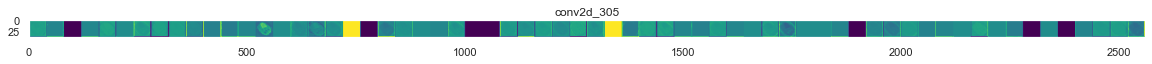

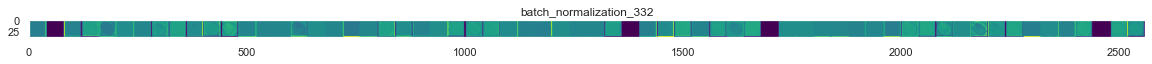

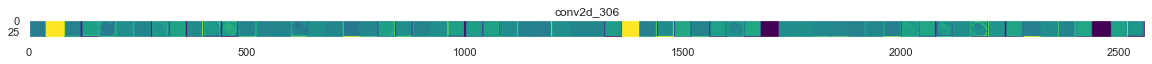

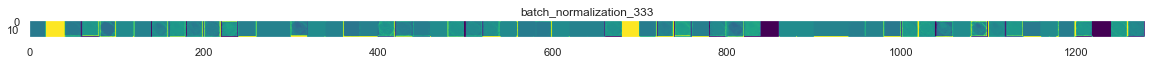

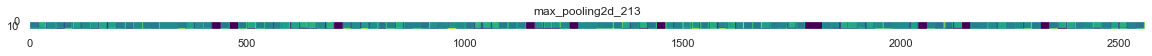

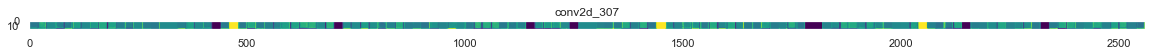

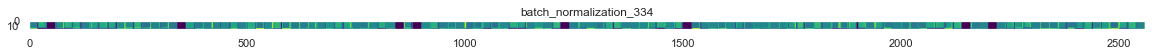

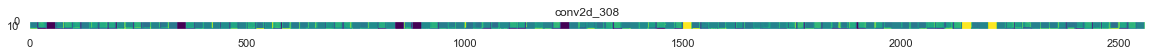

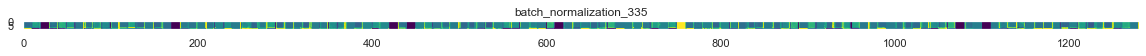

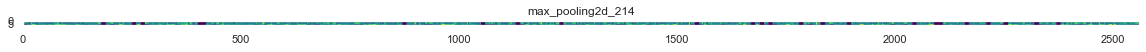

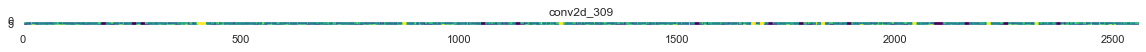

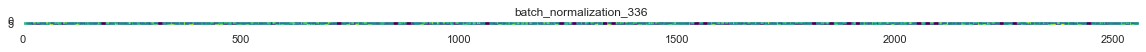

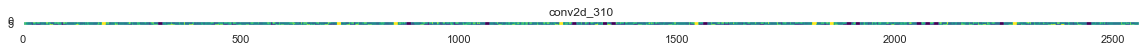

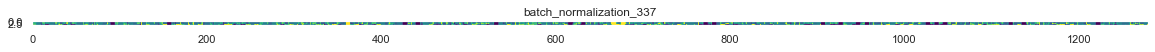

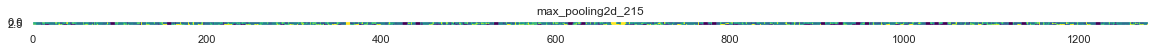

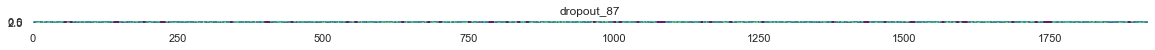

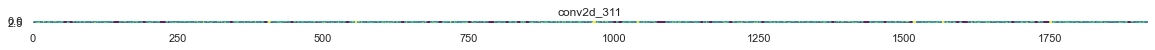

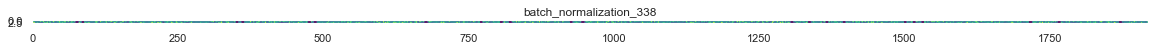

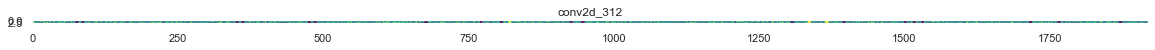

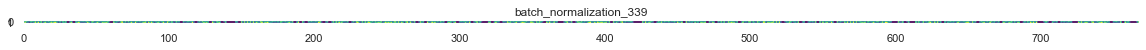

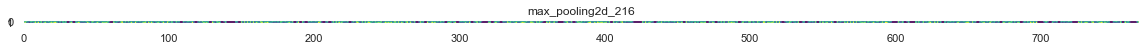

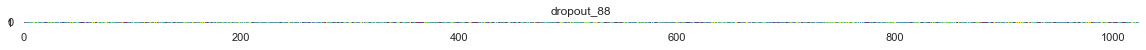

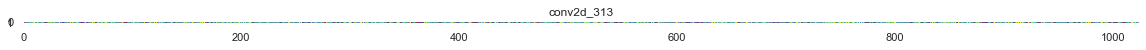

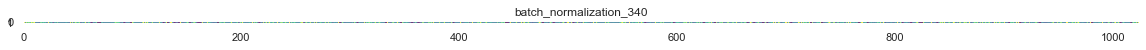

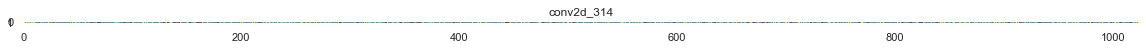

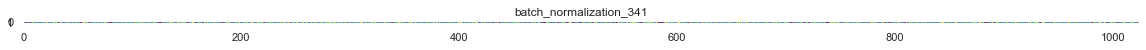

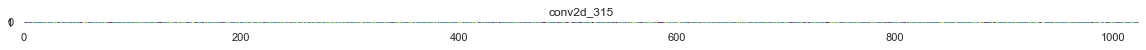

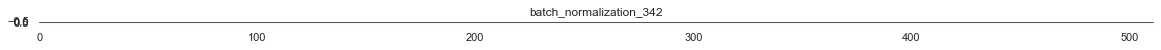

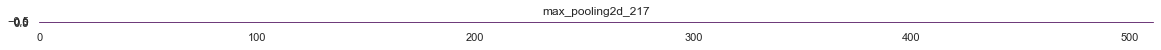

In [236]:
for layer_names1, feature_maps in zip(layer_names,feature_maps):
    print(feature_maps.shape)
    if len(feature_maps.shape) == 4:
        channels = feature_maps.shape[-1]
        size = feature_maps.shape[1]
        display_grid = np.zeros((size,size*channels))
        for i in range(channels):
            x = feature_maps[0,:,:,i]
            x-=x.mean()
            x/=x.std()
            x*=64
            x+=128
            x=np.clip(x,0,255).astype('uint8')
            display_grid[:,i*size:(i+1)*size]=x
        scale = 20./channels
        plt.figure(figsize=(scale*channels,scale))
        plt.title(layer_names1)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto',cmap='viridis')

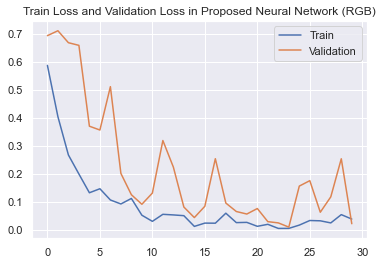

<Figure size 432x288 with 0 Axes>

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# plot the loss
plt.plot(mod.history['loss'], label='Train')
plt.plot(mod.history['val_loss'], label='Validation')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
plt.title('Train Loss and Validation Loss in Proposed Neural Network (RGB)')
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


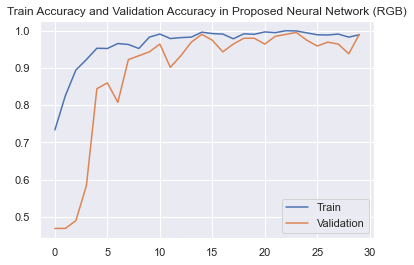

<Figure size 432x288 with 0 Axes>

In [197]:
plt.plot(mod.history['accuracy'], label='Train')
plt.plot(mod.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Train Accuracy and Validation Accuracy in Proposed Neural Network (RGB)')
plt.show()
plt.savefig('AccVal_acc_nonaugmented')
